# Ejercicio de Trabajo en Clases 06: YOLOv5 - Detección de Mascarilla

<font color='red'>No se aceptan soluciones que usen metodologías distintas a las vistas en clases.</font>

<font color='orange'>Está permitido usar los códigos de los ejemplos vistos en clases.</font>



En este ejercicio se debe entrenar y probar un modelo de detección de mascarillas usando YOLOv5.

<font color='red'>La solución debe basarse en los ejemplos vistos en clases.</font>






# 0) Cambiar el nombre del archivo

<font color='red'>WARNING-2: CAMBIA EL NOMBRE DEL ARCHIVO ipynb INCLUYENDO TU RUT</font>

Ejemplo, si tu RUT es 12.345.678-9, el nombre de este archivo debe cambiarse de "E06_Tu_Rut.ipynb" a "E06_12345678-9.ipynb"


# 1) Definición de la base de datos

(1 puntos)

Cargue la base de datos del ejemplo visto en clases que se encuentra en

`https://www.dropbox.com/s/mbtbb80wglvtcg2/YOLOimages_eye_mouth.zip`.


In [1]:
!wget https://www.dropbox.com/s/mbtbb80wglvtcg2/YOLOimages_eye_mouth.zip
!unzip -qq YOLOimages_eye_mouth.zip

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch
from tqdm.auto import tqdm
import numpy as np

--2024-10-12 18:04:02--  https://www.dropbox.com/s/mbtbb80wglvtcg2/YOLOimages_eye_mouth.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/zbw849mhac2168k343g9j/YOLOimages_eye_mouth.zip?rlkey=0nxp1eohbvqz1cq3bgv1tce9g [following]
--2024-10-12 18:04:02--  https://www.dropbox.com/scl/fi/zbw849mhac2168k343g9j/YOLOimages_eye_mouth.zip?rlkey=0nxp1eohbvqz1cq3bgv1tce9g
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc53305248782ed609030b4db156.dl.dropboxusercontent.com/cd/0/inline/CcXALBKhA037XTOcPVSfNOKg0CjcQv-L_8GOqSU_2QQRFyl0vDeFalwTy1ZGd1vkebc-jg2UHZwz_ea-_Giabe67SgA-nDMTiaE65L7h_ScsRGvJpGQbEmZ6ZZMI_Dtd83I/file# [following]
--2024-10-12 18:04:03--  https://uc53305248782ed609030b4db156.dl.dropboxusercontent.co

# 2) Anotaciones de bounding boxes y clases

(3 puntos)

Crear un archivo `csv` que contenga las anotaciones y las clases y carguela un variable dataframe llamada `df` (de la librería pandas). Observe que en esta base de datos hay 198 imágenes a color de 33 personas. Cada persona tiene 3 fotos sin mascarilla y 3 fotos con mascarilla. El tamaño de cada imagen es de 256x256 pixeles. El nombre de las imágenes es `FM000xxx_nn.jpg`, donde `xxx` es el ID de la persona, y `nn` es el número de la foto de la persona, con `nn = 1,...6`.

<font color='orange'>Las tres primeras fotos `nn=1,2,3` de la persona son sin mascarilla, mientras que las últimas tres `nn=4,5,6` son con mascarilla.</font>

<font color='red'>NO HACER ANOTACIÓN MANUAL:</font> como las caras en esta base de datos están centradas, asuma que TODAS las mascarillas están en la posición `x1 = 50`, `x2 = 206`, 	` y1 = 110`, `y2 = 226`. (esto no es perefecto pero es una muy buena aproximación práctica).

No olvidar que en este problema sólo hay una clase que detectar, y que esta clase es la clase `0`.


In [2]:
x1, y1 = 50, 110
x2, y2 = 206, 226
annotations = []
images_dir = "images"

for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):
        photo_num = int(filename[9:11])
        if photo_num > 3:
            annotations.append([filename, x1, x2, y1, y2, 0])

df = pd.DataFrame(
    annotations,
    columns=["File", "x1", "x2", "y1", "y2", "c"]
)

df.to_csv("YOLObb_masks.csv", index=False)

print(df.head())


              File  x1   x2   y1   y2  c
0  FM000056_04.jpg  50  206  110  226  0
1  FM000154_04.jpg  50  206  110  226  0
2  FM000008_04.jpg  50  206  110  226  0
3  FM000155_04.jpg  50  206  110  226  0
4  FM000163_06.jpg  50  206  110  226  0


# 2.1) Despliegue una imagen de ejemplo con bounding box

(1 punto)

Despliegue una imagen de la base de datos mostrando un bounding box con la mascarilla.

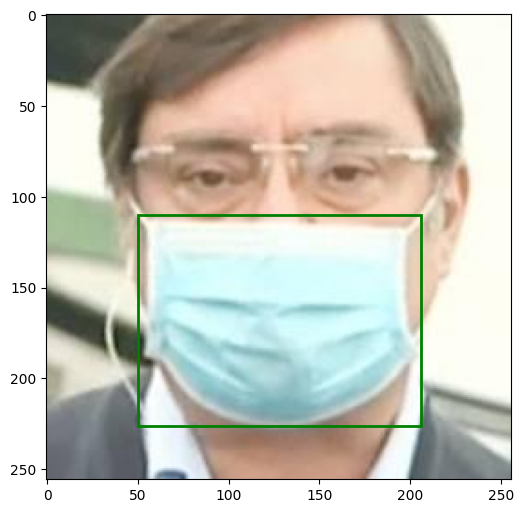

In [3]:
df = pd.read_csv("YOLObb_masks.csv")
sample = df.iloc[0]
file_name = sample["File"]
x1, x2, y1, y2 = sample["x1"], sample["x2"], sample["y1"], sample["y2"]
image_path = f"images/{file_name}"
X = cv2.imread(image_path)
X_rgb = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 8))
plt.imshow(X_rgb)

plt.gca().add_patch(
    plt.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        edgecolor="green",
        facecolor="none",
        linewidth=2
    )
)

plt.show()


# 3) Genere los archivos para los formatos adecuados de YOLOv5

(1 punto)

Genere los archivos de texto en el formato adecuado de YOLO con las coordenadas normalizadas de los bounding boxes y el número de la clase de las imágenes que contienen mascarilla. Los archivos de texto deben guardarse en el directorio `labels`.

In [4]:
!mkdir data
!mkdir data/images
!mkdir data/images/train
!mkdir data/images/val
!mkdir data/images/test
!mkdir data/labels
!mkdir data/labels/train
!mkdir data/labels/val
!mkdir data/labels/test

# 4) Definición de subconjuntos de Training/Validation/Testing

(1 punto)

Divida las imágenes del dataset de la siguiente manera:

* las primeras 125 imágenes para el training,

* las siguientes 14 para validation,

* las últimas 59 para el testing.


Las imágenes (con sus archivos de texto de los labels correspondientes) deben ser copiados en los siguientes directorios:



```
data
   |——————images
   |        └——————train —— <trainimage01>.jpg
   |        |               <trainimage02>.jpg
   |        |                      :
   |        └——————val   —— <valimage01>.jpg
   |        |               <valimage02>.jpg
   |        |                      :
   |        └——————test —— <testimage01>.jpg
   |        |               <testimage02>.jpg
   |        |                      :
   └——————labels
   |        └——————train —— <trainimage01>.txt
   |        |               <trainimage02>.txt
   |        |                      :
   |        └——————val   —— <valimage01>.txt
   |        |               <valimage02>.txt
   |        |                      :
   |        └——————test —— <testimage01>.txt
   |        |               <testimage02>.txt
   |        |                      :
```


In [5]:
def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names
d = dirfiles('images/','*.jpg')

In [6]:
!mkdir labels

In [7]:
from tqdm.auto import tqdm
m = len(d) # numero de imagenes
n = len(df) # numero de bounding boxes


for i in tqdm(range(m)):
  fname = d[i]
  X = cv2.imread('images/'+fname)
  N = X.shape[0]
  M = X.shape[1]
  # filas que contienen la imagen con nombre fname
  ok = 0
  for k in range(n):
    tname = fname[:-3]+'txt'
    if df.File[k] == fname:
      x1 = df.x1[k]
      x2 = df.x2[k]
      y1 = df.y1[k]
      y2 = df.y2[k]
      c  = df.c[k]
      wn = (x2-x1)/M
      hn = (y2-y1)/N
      xn = (x1+x2)/2/M
      yn = (y1+y2)/2/N
      if ok == 0:
        f = open('labels/'+tname,'w+')
        ok = 1
      f.write(str(c)+' '+str(xn)+' '+str(yn)+' '+str(wn)+' '+str(hn)+'\n')
  if ok:
    f.close()

  0%|          | 0/198 [00:00<?, ?it/s]

In [8]:
p_train = 0.7  # 70% del total de los datos son training
p_val   = 0.1

d = dirfiles('images/','*.jpg')
m = len(d) # número de imagenes

nt = round(p_train*m)
nv = round(p_val*nt)

ii = np.vstack([np.zeros((nt-nv,1)),np.ones((nv,1)),2*np.ones((m-nt,1))])

target = ['train','val','test']

for i in tqdm(range(m)):
  fname            = d[i]
  tname            = fname[:-3]+'txt'
  ti               = target[int(ii[i])]
  source_file      = 'images/'+fname
  destination_file = 'data/images/'+ti
  os.system('cp ' + source_file + ' ' + destination_file)
  source_file      = 'labels/'+tname
  destination_file = 'data/labels/'+ti
  # print(destination_file)
  os.system('cp ' + source_file + ' ' + destination_file)

print('Training: ', nt-nv)
print('     Val: ', nv)
print(' Testing: ',m-nt)

  0%|          | 0/198 [00:00<?, ?it/s]

<ipython-input-8-43f657abc16c>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ti               = target[int(ii[i])]


Training:  125
     Val:  14
 Testing:  59


# 5) Defina el archivo YAML para este problema

Defina el archivo `data/data.yaml` que contiene la información de:

* los directorios de training, validation y testing

* el nombre de las clases

* el número de clases

In [9]:
PATH_TRAIN = 'data/images/train'
PATH_VAL   = 'data/images/val'
PATH_TEST  = 'data/images/test'
N_CLASSES  = 1 # 0: mask

class_names = ['mask']


f = open('data/data.yaml','w+')

f.write('train: ../'+PATH_TRAIN+'\n')
f.write('val:   ../'+PATH_VAL+'\n')
f.write('test:  ../'+PATH_TEST+'\n')
f.write('nc:  '+str(N_CLASSES)+'\n')
f.write('names:  '+str(class_names)+'\n')

f.close()

!cat data/data.yaml

train: ../data/images/train
val:   ../data/images/val
test:  ../data/images/test
nc:  1
names:  ['mask']


# 6) Instale YOLOv5

(1 punto)

In [10]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00
Cloning into 'yolov5'...
remote: Enumerating objects: 16982, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 16982 (delta 91), reused 109 (delta 53), pack-reused 16805 (from 1)
Receiving objects: 100% (16982/16982), 15.71 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (11620/11620), done.
/content/yolov5


# 7) Defina las variables necesarias para el entrenamiento de YOLOv5

(1 punto)

Defina las siguientes variables:

* `YOLO_MODEL` : para usar modelo "yolov5s"

* `EPOCHS`: para 100 épocas

* `CFG`: con el nombre del archivo YAML de este modelo

* `TRAIN_WEIGHTS`: con el nombre del archivo `pt` que contiene los pesos pre-entrenados de este modelo

* `BATCH`: para que entrene con un batch de 8

* `IMG_SIZE`: con el tamaño de la imágen

* `YAMLFILE`: con el path del archivo `data.yaml` diseñado para este problema en el paso 5).

In [11]:
YOLO_MODEL     = 'yolov5s' # puede ser yolov5m, yolov5l, yolov5x
EPOCHS         = 100
CFG            = YOLO_MODEL+'.yaml'
TRAIN_WEIGHTS  = YOLO_MODEL+'.pt'  # o pesos de otro modelo propio pre-entrenado
BATCH          = 8
IMG_SIZE       = 256
YAMLFILE       = '../data/data.yaml'

#8) Entrene YOLOv5

(2 puntos)

Entre el modelo YOLOv5 usando las variables definidas en el paso anterior.

<font color='orange'>Asegúrese que Colab esté usando GPU.</font>




In [12]:
!python train.py --img {IMG_SIZE} --batch {BATCH} --epochs {EPOCHS} --data {YAMLFILE} --cfg {CFG} --weights {TRAIN_WEIGHTS} --nosave --cache

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2024-10-12 18:05:22.377875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 18:05:22.397532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 18:05:22.403655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=../d

# 10) Detección en el testing

(2 puntos)

Pruebe el modelo en las imágenes del testing, y despliegue los resultados para la imagen `FM000155_04.jpg`


detect: weights=['runs/train/exp/weights/last.pt'], source=../data/images/test, data=data/coco128.yaml, imgsz=[256, 256], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-372-ga3555241 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/59 /content/data/images/test/FM000145_02.jpg: 256x256 (no detections), 5.8ms
image 2/59 /content/data/images/test/FM000145_03.jpg: 256x256 (no detections), 6.0ms
WARNING ⚠️ NMS time limit 0.550s exceeded
image 3/59 /content/data/images/test/FM000145_04.jpg: 256x256 1 mask, 5.8ms
image 4/59 /content/data/

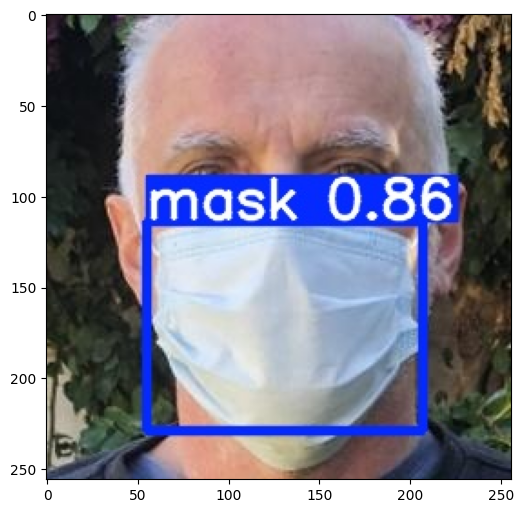

In [13]:
TEST_WEIGHTS = 'runs/train/exp/weights/last.pt'  # ver path en las ultimas lineas de la ejecución anterior
PATH_TEST    = '../data/images/test'

!python detect.py --weights {TEST_WEIGHTS} --img 256 --conf 0.4 --source  {PATH_TEST}

X = cv2.imread('runs/detect/exp/FM000155_04.jpg')

plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
plt.show()

# 11) Estadísticas en testing

(2 puntos)

Grafique la curva de precision-recall del testing con el valor `mAP`

val: data=../data/data.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=256, conf_thres=0.001, iou_thres=0.25, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-372-ga3555241 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/data/labels/val.cache... 7 images, 7 backgrounds, 0 corrupt: 100% 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.34s/it]
                   all         14          7      0.989          1      0.995      0.839
Speed: 0.1ms pre-process, 13.6ms inference, 68.0ms NMS per image at shape (32, 3, 256, 256)
Results saved to runs/val/exp


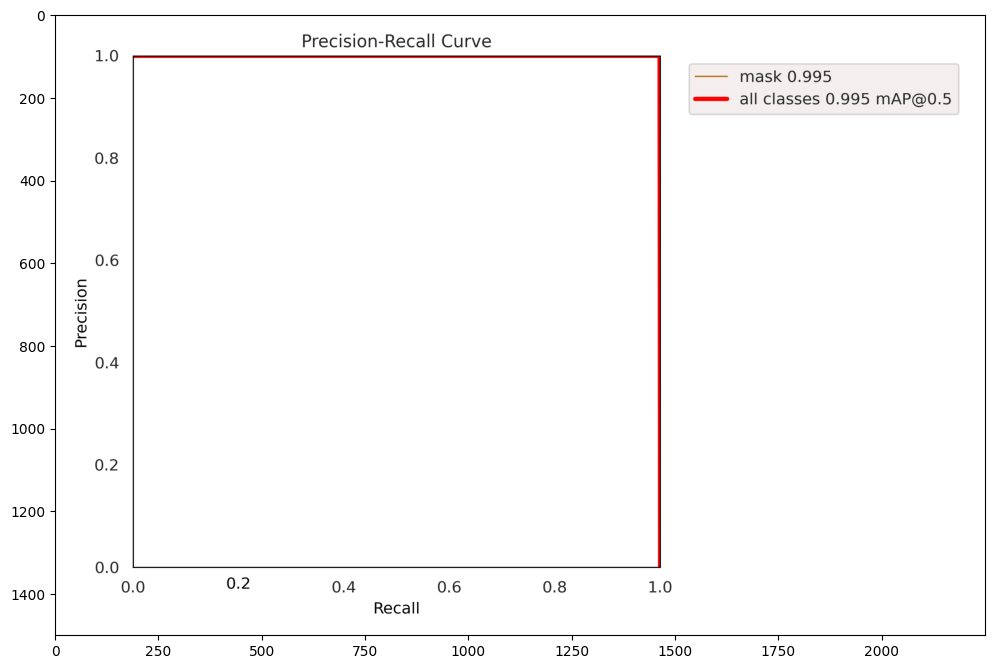

In [14]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --half
I = cv2.imread('runs/val/exp/PR_curve.png') # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

val: data=../data/data.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=256, conf_thres=0.001, iou_thres=0.25, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-372-ga3555241 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/data/labels/test... 30 images, 29 backgrounds, 0 corrupt: 100% 59/59 [00:00<00:00, 1664.19it/s]
test: New cache created: /content/data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:01<00:00,  1.53it/s]
                   all         59         30      0.996          1      0.995       0.82
Speed: 0.1ms pre-process, 4.2ms inference, 10.2ms NMS per image at s

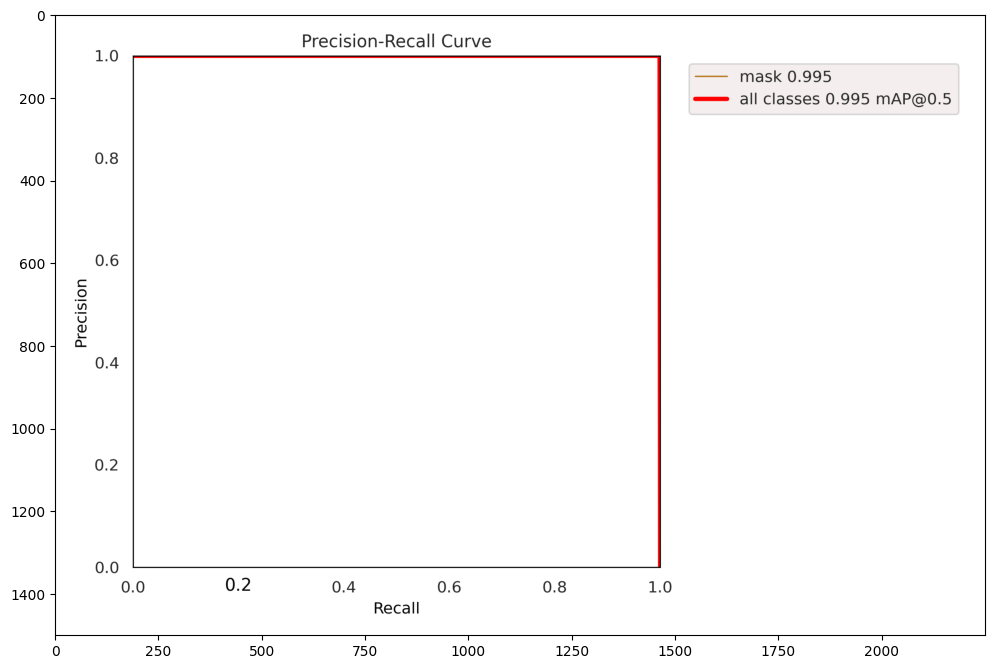

In [15]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --task test

I = cv2.imread('runs/val/exp2/PR_curve.png')  # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

# 12) Pruebe el modelo con una imagen nueva

(2 puntos)

Verifique la efectividad del modelo de detección de mascarillas entrenado en este ejercicio con la imagen disponible en `https://www.dropbox.com/s/vrquzkxagy7vyi1/testface.png`

In [16]:
!wget https://www.dropbox.com/s/vrquzkxagy7vyi1/testface.png
NEW_PATH_TEST = '../newtest'
TEST_IMAGE    = 'testface.png'
!mkdir {NEW_PATH_TEST}
!cp {TEST_IMAGE} {NEW_PATH_TEST}
!python detect.py --weights {TEST_WEIGHTS} --img 256 --conf 0.4 --source  {NEW_PATH_TEST} --save-txt

--2024-10-12 18:09:54--  https://www.dropbox.com/s/vrquzkxagy7vyi1/testface.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5cja36mn3xs0lug6m8vzq/testface.png?rlkey=e0qcu5d40c1s83wlhgb82p1fi [following]
--2024-10-12 18:09:54--  https://www.dropbox.com/scl/fi/5cja36mn3xs0lug6m8vzq/testface.png?rlkey=e0qcu5d40c1s83wlhgb82p1fi
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf1a4f5eec18edfface72fffd61.dl.dropboxusercontent.com/cd/0/inline/CcWBHJGwptrrx5LUTDEnXqLQDiZytakO2HSAP-LJ7T3pRlhgawCzZJn4C1-ISIQIlOQ_AMnn8DhGWki88YVvESDdSWPH-mAF_6sNxUoi5YX8wTqsi0xIib6cV-HeA0lsHgs/file# [following]
--2024-10-12 18:09:55--  https://ucf1a4f5eec18edfface72fffd61.dl.dropboxusercontent.com/cd/0/inline/CcWBHJGwptrrx5LUTDEnXq

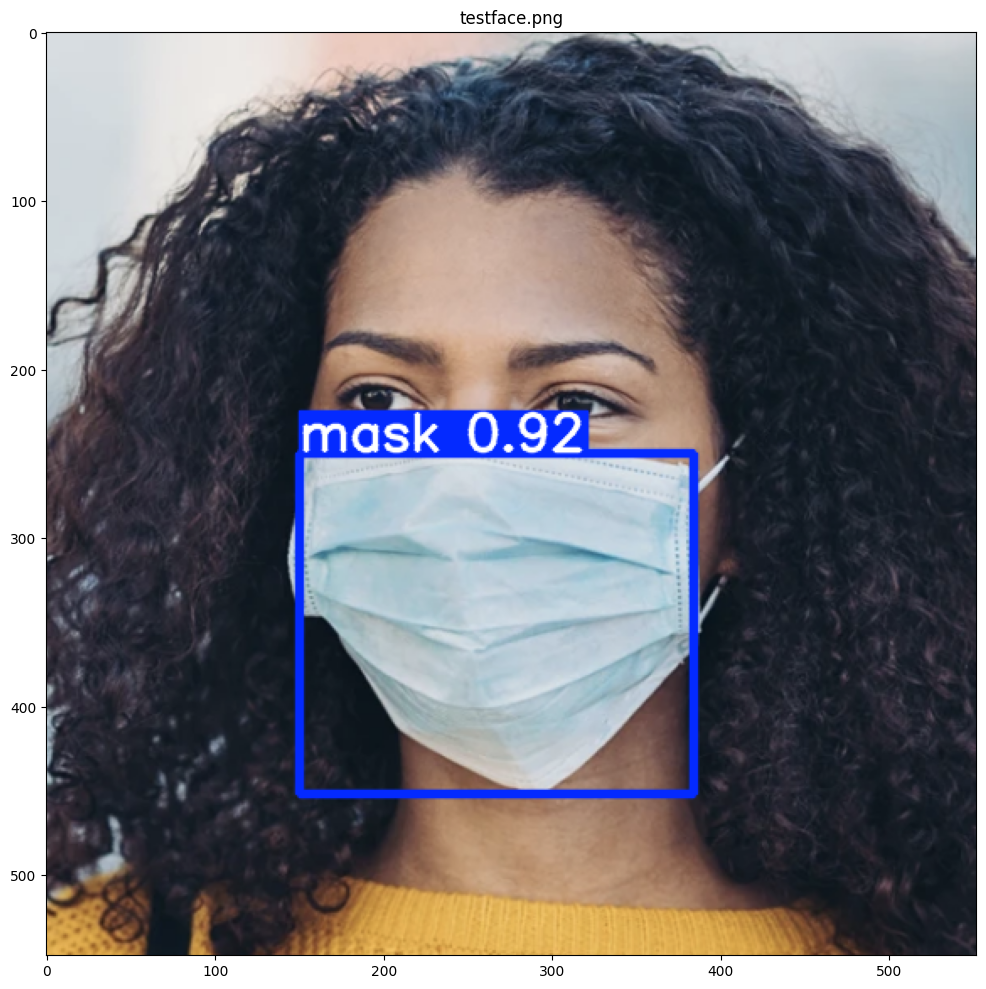

In [17]:
X = cv2.imread('runs/detect/exp2/'+TEST_IMAGE) # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
plt.title(TEST_IMAGE)
plt.show()


In [18]:
def plot_boundingbox(iname,img_path,label_path):
  img_name = img_path +'/'+iname
  print('image:',img_name)
  X = cv2.imread(img_name)
  N = X.shape[0]
  M = X.shape[1]
  plt.figure(figsize=(12,12))
  plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
  plt.title(iname)
  lname = label_path+iname[:-4]+'.txt'
  print(' bbox:',lname)
  if os.path.isfile(lname):
    arr = np.loadtxt(lname)
    if len(arr.shape)==1:
      n = 1
    else:
      n = arr.shape[0]
    for k in range(n):
      if n>1:
        z = arr[k,:]
      else:
        z = arr
      cl = int(z[0]) # object class
      x = z[1]*M
      y = z[2]*N
      w2 = z[3]*M/2
      h2 = z[4]*N/2
      x1 = x-w2
      x2 = x+w2
      y1 = y-h2
      y2 = y+h2
      plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'g')
      plt.text(x1,y1,str(cl),bbox=dict(facecolor='red', alpha=0.5))
      #k = k+1

  plt.show()


image: ../newtest/testface.png
 bbox: runs/detect/exp2/labels/testface.txt


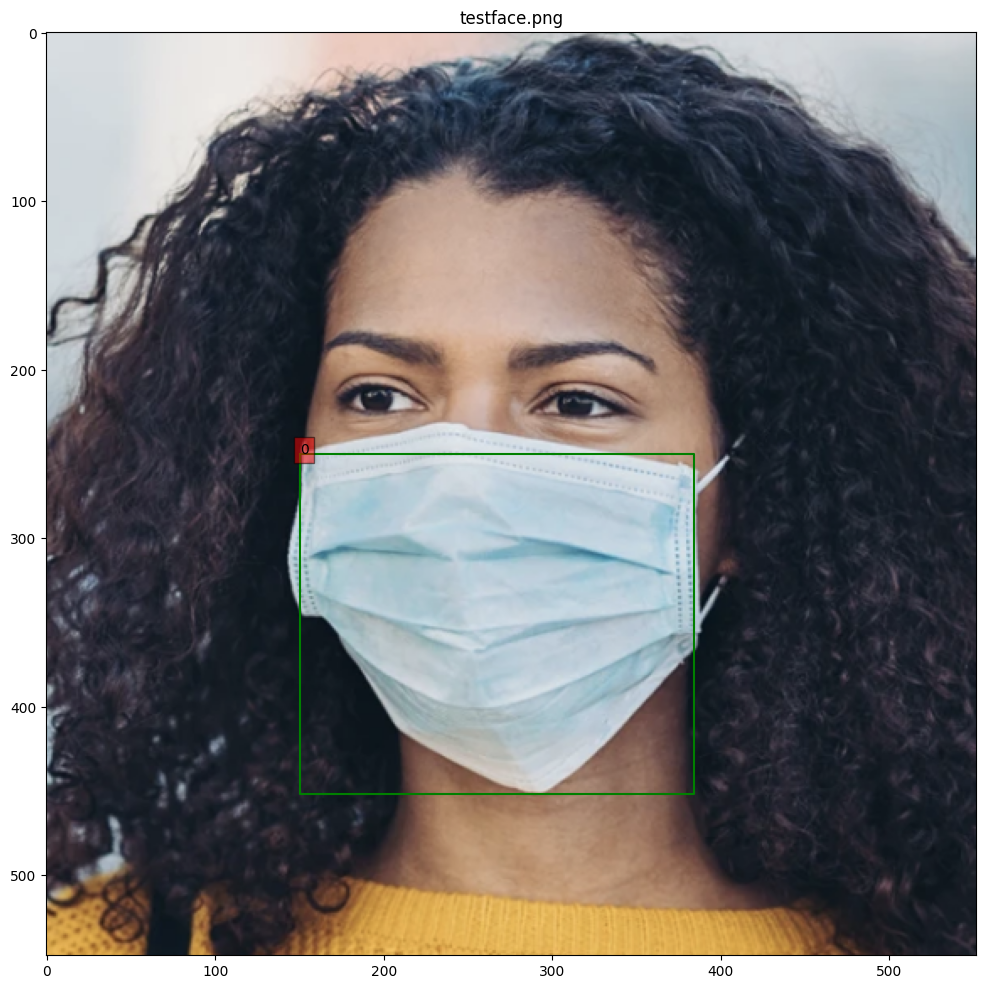

In [19]:
iname = TEST_IMAGE
img_path = NEW_PATH_TEST
label_path = 'runs/detect/exp2/labels/' # ver path en las ultimas lineas de la ejecución anterior
plot_boundingbox(iname,img_path,label_path)

# <font color='red'>SUBIR EJERCICIO DE FORMA INDIVIDUAL A CANVAS</font>

